## Initial loading of libraries and dataset

In [2]:
# Connect the necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import ReLU, Dense, LSTM, Dropout, BatchNormalization, Conv2D, Reshape, Input, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_decode, ctc_batch_cost
from matplotlib import pyplot as plt
from jiwer import wer

In [1]:
# Load dataset
from tensorflow_datasets import load
train_data, test_data = load("ljspeech", split=["train[:90%]", "train[90%:]"], as_supervised=True)

In [3]:
# Configuration
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token='')
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)
SAMPLE_RATE = 22050
FFT_LENGTH = 384

In [4]:
# Function for preprocessing samples
def process_sample(label, audio):
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=160, fft_length=FFT_LENGTH)
    spectrogram = tf.math.pow(tf.math.abs(spectrogram), 0.5)
    mean = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    std = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - mean) / (std + 1e-10)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label = char_to_num(label)
    return spectrogram, label

In [5]:
# Data preprocessing
train_preprocessed = (train_data.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
                      .padded_batch(32)
                      .prefetch(buffer_size=tf.data.AUTOTUNE))
test_preprocessed = (test_data.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
                     .padded_batch(32)
                     .prefetch(buffer_size=tf.data.AUTOTUNE))

In [6]:
# Function to calculate CTC loss
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_len = input_len * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_len = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = ctc_batch_cost(y_true, y_pred, input_len, label_len)
    return loss

## Working with neural network

In [20]:
# Function to build the model
def build_model(input_dim, output_dim, num_rnn_layers, rnn_units):
    inputs = Input(shape=(None, input_dim))
    x = Reshape((-1, input_dim, 1))(inputs)

    # CNN layers
    x = Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Transformation for RNN
    x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # Bi-LSTM layers
    for i in range(num_rnn_layers):
        recurrent = LSTM(units=rnn_units, activation="tanh", recurrent_activation="sigmoid",
                         use_bias=True, return_sequences=True)
        x = Bidirectional(recurrent, merge_mode="concat")(x)
        if i < num_rnn_layers - 1:
            x = Dropout(rate=0.5)(x)

    # Final Dense layers
    x = Dense(rnn_units * 2)(x)
    x = ReLU()(x)
    x = Dropout(rate=0.5)(x)
    outputs = Dense(output_dim + 1, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=ctc_loss)
    return model

In [21]:
# Build the model
input_dim = FFT_LENGTH // 2 + 1
output_dim = char_to_num.vocabulary_size()
num_rnn_layers = 5
rnn_units = 512
model = build_model(input_dim, output_dim, num_rnn_layers, rnn_units)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 97, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 49, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 1024)          │       8,523,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 35,039,616 (133.67 MB)

 Trainable params: 35,039,488 (133.67 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:
# Function for decoding predictions
def decode_predictions(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    results = ctc_decode(predictions, input_length=input_len, greedy=True)[0][0].numpy()
    decoded = []
    for result in results:
        text = tf.strings.reduce_join(num_to_char(result)).numpy().decode('utf-8')
        decoded.append(text)
    return decoded

In [25]:
# Train the model
history = model.fit(train_preprocessed, validation_data=test_preprocessed, epochs=5)

Epoch 1/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 1638s 4s/step - loss: 315.8869 - val_loss: 314.7951
Epoch 2/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - loss: 281.8203 - val_loss: 204.8728
Epoch 3/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 1110s 3s/step - loss: 183.9794 - val_loss: 109.5832
Epoch 4/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - loss: 116.2057 - val_loss: 83.7035
Epoch 5/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 1160s 3s/step - loss: 88.9695 - val_loss: 68.9837


In [26]:
# Save the model
model.save("sound_model.h5")

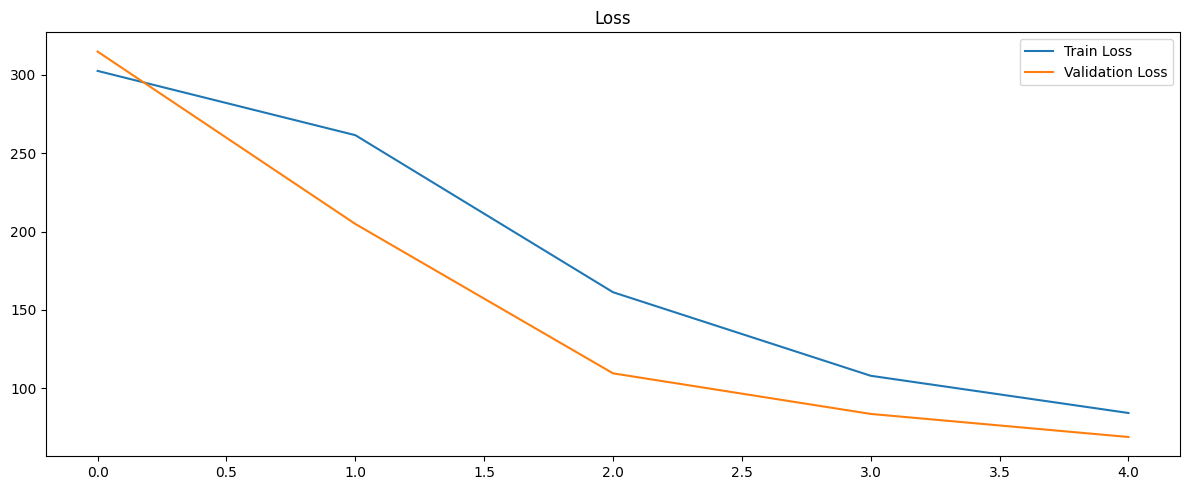

In [28]:
# Plot graphs
plt.figure(figsize=(12, 5))
plt.title("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Load model with custom functions
model = load_model("sound_model.h5", custom_objects={"ctc_loss": ctc_loss})

# Evaluation on test data
for spectrograms, labels in test_preprocessed.take(1):
    predictions = model.predict(spectrograms)
    decoded_predictions = decode_predictions(predictions)
    true_labels = [tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8') for label in labels]

    for true, pred in zip(true_labels, decoded_predictions):
        print(f"True: {true}\nPred: {pred}\nWER: {wer(true, pred)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
True: again in eighteen thirtyfive prisons and their inmates became once more the care of the senate and the subject was taken up this time by the house of lords
Pred: ta gan in eighteen thirtyfive prisons and their in mates became once more the care of the senit and the subdict was taken out this time by the house of lords
WER: 0.2413793103448276

True: he would not give him a visa end quote and that quote
Pred: he would not give him of veasea end quote and that quote
WER: 0.16666666666666666

True: the rest were detained for more than a month it being considered that they were the most guilty as being either professional agents who advised the others to abscond
Pred: the rest ter detained for mor that a moth it be inconsidered that they werthe most gilty as being ither prfectional agens ho vized the others to escone
WER: 0.5172413793103449

True: the trial of miss edmunds was transferred to the central criminal court under lord campbell's act alr